In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pwd

'/home/ubuntu/nbs'

In [3]:
train = pd.read_csv('/home/ubuntu/Data/MLC4/train_data.csv')
test = pd.read_csv('/home/ubuntu/Data/MLC4/test_data.csv')

In [4]:
id_test = test['connection_id'].values

In [5]:
train.shape

(169307, 43)

In [6]:
train.head(2)

,connection_id,cont_1,cont_2,cont_3,cont_4,cont_5,cont_6,cont_7,cont_8,cont_9,...,cat_15,cat_16,cat_17,cat_18,cat_19,cat_20,cat_21,cat_22,cat_23,target
0,cxcon_1,0,1032,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,511,511,255,255,2
1,cxcon_4,0,520,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,511,511,255,255,0


In [7]:
train['target'].value_counts()

0    98868
2    36854
1    33585
Name: target, dtype: int64

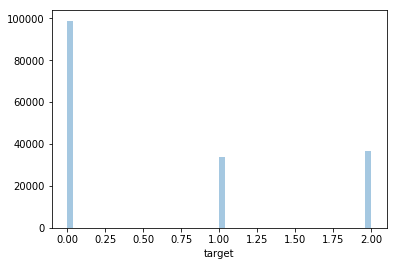

In [8]:
sns.distplot(train['target'], kde=False)

In [9]:
train.columns

Index(['connection_id', 'cont_1', 'cont_2', 'cont_3', 'cont_4', 'cont_5',
       'cont_6', 'cont_7', 'cont_8', 'cont_9', 'cont_10', 'cont_11', 'cont_12',
       'cont_13', 'cont_14', 'cont_15', 'cont_16', 'cont_17', 'cont_18',
       'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8',
       'cat_9', 'cat_10', 'cat_11', 'cat_12', 'cat_13', 'cat_14', 'cat_15',
       'cat_16', 'cat_17', 'cat_18', 'cat_19', 'cat_20', 'cat_21', 'cat_22',
       'cat_23', 'target'],
      dtype='object')

In [10]:
#train.nunique()

In [11]:
test.shape

(91166, 42)

In [12]:
train_features = [x for x in train.columns if x not in ['connection_id','target']]

X = train[train_features].values
y = train.loc[:,'target'].values
T = test[train_features].values

#create the models
# LightGBM params
lgb_params_1 = {
    'learning_rate': 0.01,
    'n_estimators': 1250,
    'max_bin': 10,
    'subsample': 0.8,
    'subsample_freq': 10,
    'colsample_bytree': 0.8, 
    'min_child_samples': 500
}

lgb_params_2 = {
    'learning_rate': 0.005,
    'n_estimators': 2000,
    'subsample': 0.7,
    'subsample_freq': 2,
    'colsample_bytree': 0.3,  
    'num_leaves': 16
}

lgb_params_3 = {
    'learning_rate': 0.05,
    'n_estimators': 1500,
    'subsample': 0.5,
    'subsample_freq': 6,
    'colsample_bytree': 0.5,  
    'num_leaves': 10
}

lgb_params_4 = {
   'objective':'binary:logistic',
   'learning_rate':0.02,
    'n_estimators':1000,
    'max_depth':4,
    'subsample':0.9,
    'colsample_bytree':0.9,  
    'min_child_weight':10
}

lgb_model_1 = LGBMClassifier(**lgb_params_1)
lgb_model_2 = LGBMClassifier(**lgb_params_2)
lgb_model_3 = LGBMClassifier(**lgb_params_3)

#lgb_model_3 = XGBClassifier(**lgb_params_3)
#base_models = (lgb_model_1, lgb_model_2)

base_models = (lgb_model_1, lgb_model_2, lgb_model_3)

print("models created")

models created


In [13]:
#now we have the data with equal set of positives and negatives
#lets check cross validation scores
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import mode

n_splits=5
folds = list(StratifiedKFold(n_splits, shuffle=True, random_state=10).split(X, y))
S_train = np.zeros((X.shape[0], len(base_models)))
S_test = np.zeros((T.shape[0], len(base_models)))

for i, clf in enumerate(base_models):
    S_test_i = np.zeros((T.shape[0], n_splits))
    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        print(X_train.shape)
        
        # Get positive examples
        pos_1 = pd.Series(y_train == 1)
        pos_2 = pd.Series(y_train == 2)
        # Add positive examples - 1
        X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train[pos_1])])
        y_train = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_train[pos_1])])
        # Add positive examples - 2
        X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train[pos_2])])
        y_train = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_train[pos_2])])
        
        # Shuffle data
        idx = np.arange(len(X_train))
        np.random.shuffle(idx)
        X_train = X_train.iloc[idx]
        y_train = y_train.iloc[idx]

        print ("Fit %s fold %d" % (str(clf).split('(')[0], j+1))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_holdout)
        #y_pred = clf.predict_proba(X_holdout)[:,1]  
        
        S_train[test_idx, i] = y_pred
        S_test_i[:, j] = clf.predict(T)
        #S_test_i[:, j] = clf.predict_proba(T)[:,1]
    
    #print(S_test_i)
    #print(mode(S_test_i, axis=1)[0].flatten())
    #print(S_test_i.mean(axis=1))
    S_test[:, i] = mode(S_test_i, axis=1)[0].flatten()
    #S_test[:, i] = S_test_i.mean(axis=1)
    #sns.distplot(S_test,kde=False)
    #sns.distplot(S_train,kde=False)

(135445, 41)
Fit LGBMClassifier fold 1
(135445, 41)
Fit LGBMClassifier fold 2
(135445, 41)
Fit LGBMClassifier fold 3
(135446, 41)
Fit LGBMClassifier fold 4
(135447, 41)
Fit LGBMClassifier fold 5
(135445, 41)
Fit LGBMClassifier fold 1
(135445, 41)
Fit LGBMClassifier fold 2
(135445, 41)
Fit LGBMClassifier fold 3
(135446, 41)
Fit LGBMClassifier fold 4
(135447, 41)
Fit LGBMClassifier fold 5
(135445, 41)
Fit LGBMClassifier fold 1
(135445, 41)
Fit LGBMClassifier fold 2
(135445, 41)
Fit LGBMClassifier fold 3
(135446, 41)
Fit LGBMClassifier fold 4
(135447, 41)
Fit LGBMClassifier fold 5


In [14]:
stacker = RandomForestClassifier()

results = cross_val_score(stacker, S_train, y, cv=5)
print("Stacker score: %.5f" % (results.mean()))
print(results)

print("S train size is : ", S_train.shape)
stacker.fit(S_train, y)

res = stacker.predict(S_test)

print(res)

Stacker score: 0.78108
[ 0.7812297   0.78125923  0.78084579  0.78098698  0.78109864]
S train size is :  (169307, 3)
[1 0 0 ..., 0 0 1]


In [15]:
print(stacker.feature_importances_)

[ 0.39031411  0.32188839  0.28779751]


In [16]:
print(len(res))
print(len(id_test))

91166
91166


In [17]:
pd.DataFrame(res)[0].value_counts()

0    72963
1    18198
2        5
Name: 0, dtype: int64

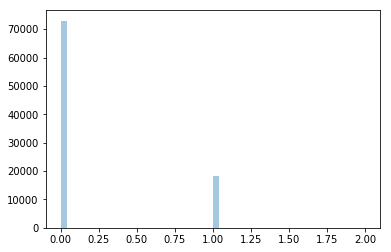

In [18]:
sns.distplot(res,kde=False)

In [19]:
print(results)
print(res)

sub = pd.DataFrame()
sub['connection_id'] = id_test
sub['target'] = res
sub.to_csv('sub_rf_stack_upsample_1.csv', index=False)

print('completed')

[ 0.7812297   0.78125923  0.78084579  0.78098698  0.78109864]
[1 0 0 ..., 0 0 1]
completed
